In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
# print(os.listdir("../input"))

In [2]:
google = pd.read_csv('../data/stock-data/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
google.head()

Open    High     Low   Close    Volume   Name
Date                                                       
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL

In [3]:
humidity = pd.read_csv('../data/weather-data/humidity.csv', index_col='datetime', parse_dates=['datetime'])
humidity.tail()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2017-11-29 20:00:00        NaN      81.0            NaN     93.0         24.0   
2017-11-29 21:00:00        NaN      71.0            NaN     87.0         21.0   
2017-11-29 22:00:00        NaN      71.0            NaN     93.0         23.0   
2017-11-29 23:00:00        NaN      71.0            NaN     87.0         14.0   
2017-11-30 00:00:00        NaN      76.0            NaN     75.0         56.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2017-11-29 20:00:00       72.0       18.0     68.0         37.0    18.0  ...   
2017-11-29 21:00:00       72.0       18.0     73.0         34.0    12.0  ...   
2017-11-29 22:00:00       68.0       17.0     60.0         32.0    15.0  ...   
2017-11-29 23:00:00       63.0       17.0     33.0         30.0    28.0  ...   
2017-11-30 00:00:00       72.0       17.0     23.0         34.0    31.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2017-11-29 20:00:00          27.0       NaN      64.0    37.0        NaN   
2017-11-29 21:00:00          29.0       NaN      59.0    74.0        NaN   
2017-11-29 22:00:00          31.0       NaN      66.0    74.0        NaN   
2017-11-29 23:00:00          26.0       NaN      58.0    56.0        NaN   
2017-11-30 00:00:00          32.0       NaN      58.0    56.0        NaN   

                     Tel Aviv District  Eilat  Haifa  Nahariyya  Jerusalem  
datetime                                                                    
2017-11-29 20:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-29 21:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-29 22:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-29 23:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-30 00:00:00                NaN    NaN    NaN        NaN        NaN  

[5 rows x 36 columns]

## 1.2 Cleaning and preparing time series data

Google stocks data 에는 누락된 데이터가 없지만 humidity data 에는 누락된 데이터가 존재함 fillna() 라는 함수를 이용해서 데이터를 채웟음 (ffill parameter 사용 -> 마지막으로 유효한 값이 들어있는걸 빈값을 채우는데 사용)

In [4]:
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method='ffill')
humidity.head()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2012-10-01 13:00:00       76.0      81.0           88.0     81.0         88.0   
2012-10-01 14:00:00       76.0      80.0           87.0     80.0         88.0   
2012-10-01 15:00:00       76.0      80.0           86.0     80.0         88.0   
2012-10-01 16:00:00       77.0      80.0           85.0     79.0         88.0   
2012-10-01 17:00:00       78.0      79.0           84.0     79.0         88.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2012-10-01 13:00:00       82.0       22.0     23.0         50.0    62.0  ...   
2012-10-01 14:00:00       81.0       21.0     23.0         49.0    62.0  ...   
2012-10-01 15:00:00       81.0       21.0     23.0         49.0    62.0  ...   
2012-10-01 16:00:00       81.0       21.0     23.0         49.0    62.0  ...   
2012-10-01 17:00:00       80.0       21.0     24.0         49.0    63.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2012-10-01 13:00:00          71.0      58.0      93.0    68.0       50.0   
2012-10-01 14:00:00          70.0      57.0      91.0    68.0       51.0   
2012-10-01 15:00:00          70.0      57.0      87.0    68.0       51.0   
2012-10-01 16:00:00          69.0      57.0      84.0    68.0       52.0   
2012-10-01 17:00:00          69.0      57.0      80.0    68.0       54.0   

                     Tel Aviv District  Eilat  Haifa  Nahariyya  Jerusalem  
datetime                                                                    
2012-10-01 13:00:00               63.0   22.0   51.0       51.0       50.0  
2012-10-01 14:00:00               62.0   22.0   51.0       51.0       50.0  
2012-10-01 15:00:00               62.0   22.0   51.0       51.0       50.0  
2012-10-01 16:00:00               62.0   22.0   51.0       51.0       50.0  
2012-10-01 17:00:00               62.0   23.0   51.0       51.0       50.0  

[5 rows x 36 columns]

## 1.3 Visualizing the datasets

In [5]:
humidity["Kansas City"].asfreq('M').plot()
 # asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
 # asfreq 함수는 입력된 parameter를 기준으로 time series를 생성해준다. 여기서는 월별로 만들어줌
plt.title('Humidity in Kansas City over time(Monthly frequency)')
plt.show()

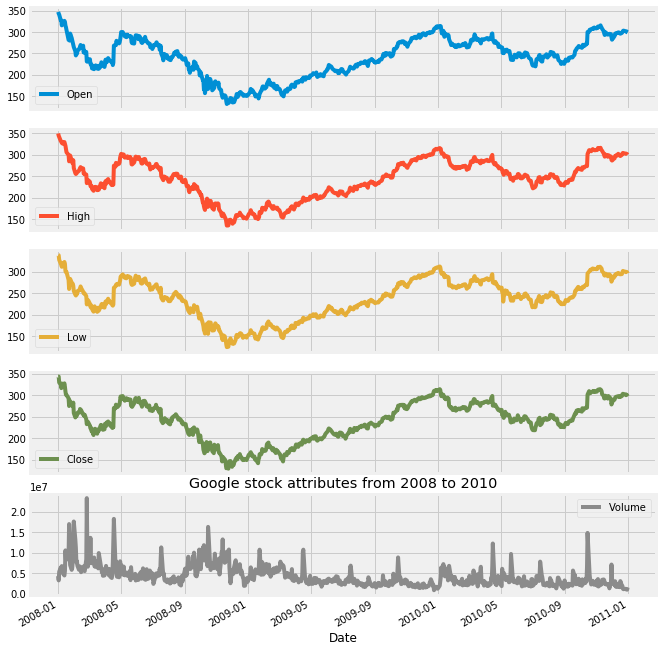

In [6]:
google['2008': '2010'].plot(subplots=True, figsize=(10, 12))
plt.title('Google stock attributes from 2008 to 2010')
plt.savefig('stocks.png')
plt.show()

## 1.4 Timestamps and Periods

In [7]:
# Timestamp 생성
timestamp = pd.Timestamp(2017, 1, 1, 12)
timestamp

Timestamp('2017-01-01 12:00:00')

In [8]:
# 기간 생성?
period = pd.Period('2017-01-01')
period

Period('2017-01-01', 'D')

In [9]:
# 생성한 timestamp 가 기간 내에 속하는지 확인
period.start_time < timestamp < period.end_time

True

In [10]:
# timestamp 를 period 로 변환
new_period = timestamp.to_period(freq='H')
new_period

Period('2017-01-01 12:00', 'H')

In [11]:
# period 를 timestamp 로 변환
new_timestamp = period.to_timestamp(freq='H', how='start')
new_timestamp

Timestamp('2017-01-01 00:00:00')

## 1.5 Using data_range

#### What is date_range and how is it useful?

date_range is a method that returns a fixed frequency datetimeindex.  
It is quite useful when creating your own time series attribute for pre-existing data  
or arranging the whole data around the time series attribute created by you.


In [12]:
# '일' 단위의 datetimeindex 생성

dr1 = pd.date_range(start='1/1/18', end='1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [13]:
# '월' 단위의 datetimeindex 생성

dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [14]:
# start 없이 datetimeindex 생성 
# periods 를 사용해서 몇개 생성할 것인지 입력

dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [15]:
# periods 를 이용해서 균등하게 일자 만들기

dr4 = pd.date_range(start='2013-04-24', end='2014-11-27', periods=3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

## 1.6 Using to_datetime

pandas.to_datetime() is used for converting arguments to datetime. Here, a DataFrame is converted to a datetime series.  
pandas.to_datetime 은 arguments 를 datetime 으로 변환한다

In [16]:
df = pd.DataFrame({'year': [2015, 2016], 'month': [2,3], 'day': [4,5]})
df

year  month  day
0  2015      2    4
1  2016      3    5

In [17]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [18]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

## 1.7 Shifting and lags

We can shift index by desired number of periods with an optional time frequency.  
This is useful when comparing the time series with a past of itself

우리는 원하는 time frequency 형태로 index를 변경할 수 있다.
이는 같은 기간의 다른 데이터들과 비교하는데 도움이 된다 

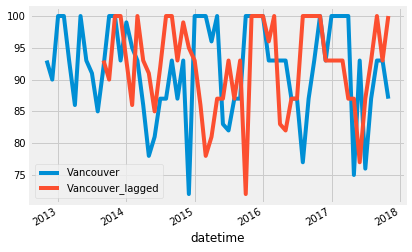

In [19]:
# 같은 그래프를 옆으로 10달 옮겼음

humidity["Vancouver"].asfreq('M').plot(legend=True)
shifted = humidity["Vancouver"].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Vancouver', 'Vancouver_lagged'])
plt.show()

## 1.8 Resampling

* Upsampling - Time series is resampled from low frequency to high frequency(Monthly to daily frequency). It involves filling or interpolating missing data

* Downsampling - Time series is resampled from high frequency to low frequency(Weekly to monthly frequency). It involves aggregation of existing data.

In [20]:
# Let's use pressure data to demonstrate this
pressure = pd.read_csv('../data/weather-data/pressure.csv', index_col='datetime', parse_dates=['datetime'])
pressure.tail()

# pressure = pd.read_csv('../data/weather-data/pressure.csv', index_col='datetime')
# pressure.tail()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2017-11-29 20:00:00        NaN    1031.0            NaN   1030.0       1016.0   
2017-11-29 21:00:00        NaN    1030.0            NaN   1030.0       1016.0   
2017-11-29 22:00:00        NaN    1030.0            NaN   1029.0       1015.0   
2017-11-29 23:00:00        NaN    1029.0            NaN   1028.0       1016.0   
2017-11-30 00:00:00        NaN    1029.0            NaN   1028.0       1015.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2017-11-29 20:00:00     1017.0     1021.0   1018.0       1025.0  1016.0  ...   
2017-11-29 21:00:00     1017.0     1020.0   1018.0       1024.0  1018.0  ...   
2017-11-29 22:00:00     1016.0     1020.0   1017.0       1024.0  1018.0  ...   
2017-11-29 23:00:00     1016.0     1020.0   1016.0       1024.0  1020.0  ...   
2017-11-30 00:00:00     1017.0     1019.0   1016.0       1024.0  1021.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2017-11-29 20:00:00        1021.0       NaN    1021.0  1017.0        NaN   
2017-11-29 21:00:00        1021.0       NaN    1023.0  1019.0        NaN   
2017-11-29 22:00:00        1022.0       NaN    1024.0  1019.0        NaN   
2017-11-29 23:00:00        1023.0       NaN    1026.0  1022.0        NaN   
2017-11-30 00:00:00        1024.0       NaN    1027.0  1023.0        NaN   

                     Tel Aviv District  Eilat  Haifa  Nahariyya  Jerusalem  
datetime                                                                    
2017-11-29 20:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-29 21:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-29 22:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-29 23:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-30 00:00:00                NaN    NaN    NaN        NaN        NaN  

[5 rows x 36 columns]

In [21]:
pressure = pressure.iloc[1:]
pressure = pressure.fillna(method='ffill')
pressure.tail()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2017-11-29 20:00:00     1021.0    1031.0         1013.0   1030.0       1016.0   
2017-11-29 21:00:00     1021.0    1030.0         1013.0   1030.0       1016.0   
2017-11-29 22:00:00     1021.0    1030.0         1013.0   1029.0       1015.0   
2017-11-29 23:00:00     1021.0    1029.0         1013.0   1028.0       1016.0   
2017-11-30 00:00:00     1021.0    1029.0         1013.0   1028.0       1015.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2017-11-29 20:00:00     1017.0     1021.0   1018.0       1025.0  1016.0  ...   
2017-11-29 21:00:00     1017.0     1020.0   1018.0       1024.0  1018.0  ...   
2017-11-29 22:00:00     1016.0     1020.0   1017.0       1024.0  1018.0  ...   
2017-11-29 23:00:00     1016.0     1020.0   1016.0       1024.0  1020.0  ...   
2017-11-30 00:00:00     1017.0     1019.0   1016.0       1024.0  1021.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2017-11-29 20:00:00        1021.0    1020.0    1021.0  1017.0      984.0   
2017-11-29 21:00:00        1021.0    1020.0    1023.0  1019.0      984.0   
2017-11-29 22:00:00        1022.0    1020.0    1024.0  1019.0      984.0   
2017-11-29 23:00:00        1023.0    1020.0    1026.0  1022.0      984.0   
2017-11-30 00:00:00        1024.0    1020.0    1027.0  1023.0      984.0   

                     Tel Aviv District  Eilat   Haifa  Nahariyya  Jerusalem  
datetime                                                                     
2017-11-29 20:00:00             1011.0  968.0  1023.0     1023.0     1011.0  
2017-11-29 21:00:00             1011.0  968.0  1023.0     1023.0     1011.0  
2017-11-29 22:00:00             1011.0  968.0  1023.0     1023.0     1011.0  
2017-11-29 23:00:00             1011.0  968.0  1023.0     1023.0     1011.0  
2017-11-30 00:00:00             1011.0  968.0  1023.0     1023.0     1011.0  

[5 rows x 36 columns]

In [22]:
pressure = pressure.fillna(method='bfill')
pressure.head()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2012-10-01 13:00:00      807.0    1024.0         1009.0   1027.0       1013.0   
2012-10-01 14:00:00      807.0    1024.0         1009.0   1027.0       1013.0   
2012-10-01 15:00:00      807.0    1024.0         1009.0   1028.0       1013.0   
2012-10-01 16:00:00      807.0    1024.0         1009.0   1028.0       1013.0   
2012-10-01 17:00:00      807.0    1024.0         1009.0   1029.0       1013.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2012-10-01 13:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 14:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 15:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 16:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 17:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2012-10-01 13:00:00        1014.0    1012.0    1001.0  1014.0      984.0   
2012-10-01 14:00:00        1014.0    1012.0     986.0  1014.0      984.0   
2012-10-01 15:00:00        1014.0    1012.0     945.0  1014.0      984.0   
2012-10-01 16:00:00        1014.0    1012.0     904.0  1014.0      984.0   
2012-10-01 17:00:00        1014.0    1012.0     863.0  1014.0      984.0   

                     Tel Aviv District   Eilat   Haifa  Nahariyya  Jerusalem  
datetime                                                                      
2012-10-01 13:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 14:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 15:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 16:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 17:00:00             1012.0  1010.0  1013.0     1013.0      990.0  

[5 rows x 36 columns]

First, we used ffill parameter which propagates last valid observation to fill gaps. Then we use bfill to propogate next valid observation to fill gaps.

In [23]:
pressure.shape

(45252, 36)

In [24]:
# downsample 작업
# 3일동안의 데이터의 평균값으로 downsampling 작업함

pressure = pressure.resample('3D').mean()
pressure.head()

Vancouver     Portland  San Francisco      Seattle  Los Angeles  \
datetime                                                                        
2012-10-01   931.627119  1022.644068    1010.881356  1031.271186  1011.627119   
2012-10-04  1019.083333  1023.041667    1014.694444  1028.305556  1015.555556   
2012-10-07  1013.930556  1017.444444    1016.597222  1018.736111  1013.416667   
2012-10-10  1015.000000  1015.430556    1014.833333  1018.416667  1010.694444   
2012-10-13  1008.152778  1018.111111    1021.069444  1015.930556  1017.277778   

              San Diego    Las Vegas      Phoenix  Albuquerque       Denver  \
datetime                                                                      
2012-10-01  1011.966102  1016.322034  1012.084746  1022.542373  1024.118644   
2012-10-04  1016.277778  1013.194444  1014.097222  1019.972222  1020.666667   
2012-10-07  1014.222222  1012.888889  1011.861111  1005.833333  1020.458333   
2012-10-10  1014.013889  1000.166667  1005.611111   986.000000   984.486111   
2012-10-13  1018.375000  1015.666667  1015.500000  1013.625000  1010.444444   

            ...  Philadelphia     New York     Montreal       Boston  \
datetime    ...                                                        
2012-10-01  ...   1014.152542  1013.423729   937.627119  1013.677966   
2012-10-04  ...   1018.097222  1017.680556  1017.180556  1019.805556   
2012-10-07  ...   1017.958333  1016.750000  1014.152778  1016.305556   
2012-10-10  ...   1018.694444  1017.916667  1016.166667  1017.319444   
2012-10-13  ...   1025.055556  1024.388889  1020.805556  1023.736111   

             Beersheba  Tel Aviv District        Eilat        Haifa  \
datetime                                                              
2012-10-01  985.050847        1012.949153  1011.796610  1013.000000   
2012-10-04  984.930556        1013.083333  1012.611111  1013.000000   
2012-10-07  982.972222        1013.027778  1007.555556  1013.000000   
2012-10-10  979.763889        1006.527778   998.763889  1012.333333   
2012-10-13  984.527778        1013.027778  1007.194444  1013.000000   

              Nahariyya   Jerusalem  
datetime                             
2012-10-01  1013.000000  990.525424  
2012-10-04  1013.000000  990.083333  
2012-10-07  1013.000000  989.833333  
2012-10-10  1012.333333  987.888889  
2012-10-13  1013.000000  990.430556  

[5 rows x 36 columns]

In [25]:
pressure.shape

(629, 36)

In [26]:
# upsampling 작업 
# 3일간의 데이터를 1일 간의 데이터로 upsampling 변환

pressure = pressure.resample('D').pad()
pressure.head()

Vancouver     Portland  San Francisco      Seattle  Los Angeles  \
datetime                                                                        
2012-10-01   931.627119  1022.644068    1010.881356  1031.271186  1011.627119   
2012-10-02   931.627119  1022.644068    1010.881356  1031.271186  1011.627119   
2012-10-03   931.627119  1022.644068    1010.881356  1031.271186  1011.627119   
2012-10-04  1019.083333  1023.041667    1014.694444  1028.305556  1015.555556   
2012-10-05  1019.083333  1023.041667    1014.694444  1028.305556  1015.555556   

              San Diego    Las Vegas      Phoenix  Albuquerque       Denver  \
datetime                                                                      
2012-10-01  1011.966102  1016.322034  1012.084746  1022.542373  1024.118644   
2012-10-02  1011.966102  1016.322034  1012.084746  1022.542373  1024.118644   
2012-10-03  1011.966102  1016.322034  1012.084746  1022.542373  1024.118644   
2012-10-04  1016.277778  1013.194444  1014.097222  1019.972222  1020.666667   
2012-10-05  1016.277778  1013.194444  1014.097222  1019.972222  1020.666667   

            ...  Philadelphia     New York     Montreal       Boston  \
datetime    ...                                                        
2012-10-01  ...   1014.152542  1013.423729   937.627119  1013.677966   
2012-10-02  ...   1014.152542  1013.423729   937.627119  1013.677966   
2012-10-03  ...   1014.152542  1013.423729   937.627119  1013.677966   
2012-10-04  ...   1018.097222  1017.680556  1017.180556  1019.805556   
2012-10-05  ...   1018.097222  1017.680556  1017.180556  1019.805556   

             Beersheba  Tel Aviv District        Eilat   Haifa  Nahariyya  \
datetime                                                                    
2012-10-01  985.050847        1012.949153  1011.796610  1013.0     1013.0   
2012-10-02  985.050847        1012.949153  1011.796610  1013.0     1013.0   
2012-10-03  985.050847        1012.949153  1011.796610  1013.0     1013.0   
2012-10-04  984.930556        1013.083333  1012.611111  1013.0     1013.0   
2012-10-05  984.930556        1013.083333  1012.611111  1013.0     1013.0   

             Jerusalem  
datetime                
2012-10-01  990.525424  
2012-10-02  990.525424  
2012-10-03  990.525424  
2012-10-04  990.083333  
2012-10-05  990.083333  

[5 rows x 36 columns]

In [27]:
pressure.shape

(1885, 36)

# 2. Finance and statistics

## 2.1 Percent change

In [28]:
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize=(20,8))

## 2.2 Stock returns

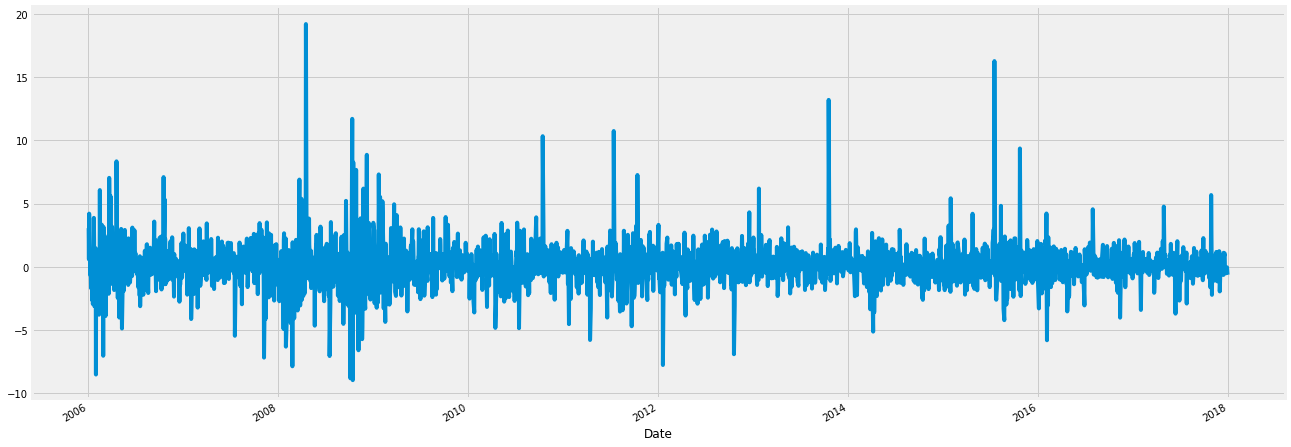

In [29]:
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20, 8))

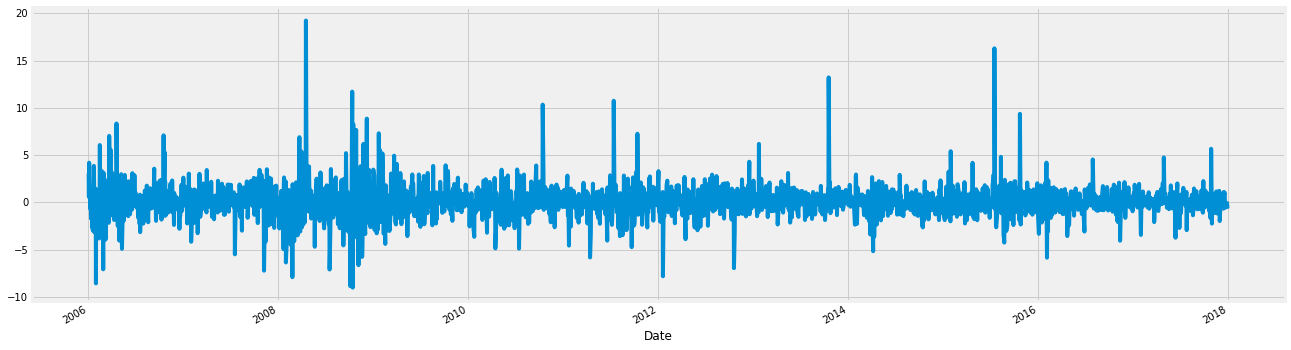

In [30]:
google.High.pct_change().mul(100).plot(figsize=(20,6))

## 2.3 Absolute change in successive rows

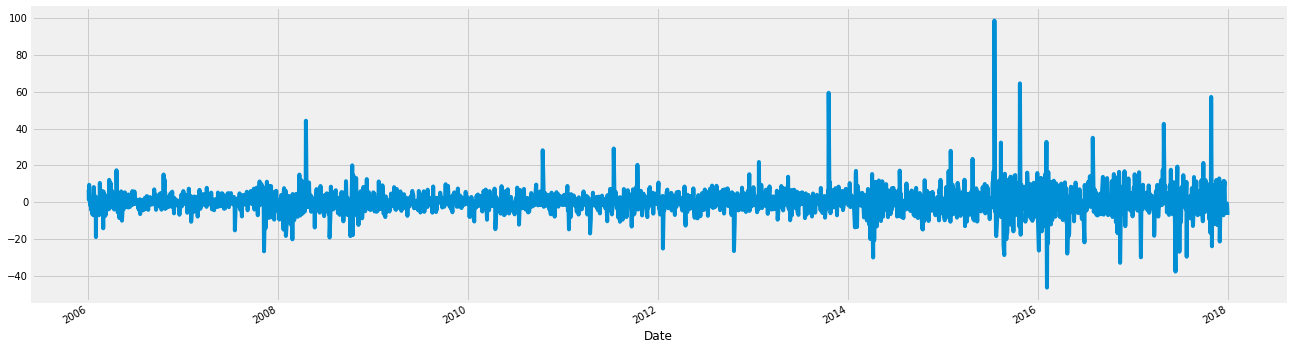

In [31]:
google.High.diff().plot(figsize=(20,6))

## 2.4 Comaring two or more time series

We will compare 2 time series by normalizing them. This is achieved by dividing each time series element of all time series by the first element. This way both series start at the same point and can be easily compared.

In [32]:
microsoft = pd.read_csv('../data/stock-data/MSFT_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

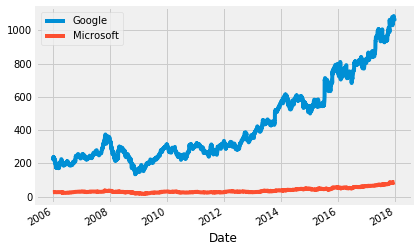

In [33]:
# Plotting before normalization
google.High.plot()
microsoft.High.plot()
plt.legend(['Google', 'Microsoft'])
plt.show()

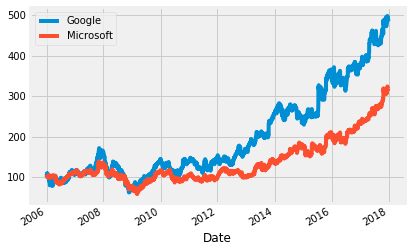

In [34]:
# Normalizing and comparison
# Both stocks start from 100
# 단지 100을 곱한 결과인가?

normalized_google = google.High.div(google.High.iloc[0]).mul(100)
normalized_microsoft = microsoft.High.div(microsoft.High.iloc[0]).mul(100)
normalized_google.plot()
normalized_microsoft.plot()
plt.legend(['Google','Microsoft'])
plt.show()

## 2.5 Window functions

Window functions are used to identify sub periods, calculates sub-metrics of sub-periods.

* Rolling - Same size and sliding
* Expanding - Contains all prior values

In [35]:
# Rolling window functions
rolling_google = google.High.rolling('90D').mean()
google.High.plot()
rolling_google.plot()
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.show()

In [36]:
# Expanding window functions
microsoft_mean = microsoft.High.expanding().mean()
microsoft_std = microsoft.High.expanding().std()
microsoft.High.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

## 2.6 OHLC chart(Open-high-low-close Charts)

In [37]:
# OHLC chart of June 2008
trace = go.Ohlc(
    x=google['06-2008'].index,
    open=google['06-2008'].Open,
    high=google['06-2008'].High,
    low=google['06-2008'].Low,
    close=google['06-2008'].Close
    )

data = [trace]
iplot(data, filename='simple_ohlc')

In [38]:
# OHLC chart of 2008
trace = go.Ohlc(
    x=google['2008'].index,
    open=google['2008'].Open,
    high=google['2008'].High,
    low=google['2008'].Low,
    close=google['2008'].Close
)

data = [trace]
iplot(data,filename='simple_ohlc')

In [39]:
# OHLC chart of all data
trace = go.Ohlc(
    x=google.index,
    open=google.Open,
    high=google.High,
    low=google.Low,
    close=google.Close
)

data = [trace]
iplot(data,filename='simple_ohlc')

## 2.7 Candlestick charts

In [40]:
# Candlestick chart of march 2008

trace = go.Candlestick(
    x=google['03-2008'].index,
    open=google['03-2008'].Open,
    high=google['03-2008'].High,
    low=google['03-2008'].Low,
    close=google['03-2008'].Close
)

data = [trace]
iplot(data, filename='simple_candlestick')

In [41]:
# Candlestick chart of 2008

trace = go.Candlestick(
    x=google['2008'].index,
    open=google['2008'].Open,
    high=google['2008'].High,
    low=google['2008'].Low,
    close=google['2008'].Close
)
data = [trace]
iplot(data, filename='simple_candlestick')

In [42]:
# Candlestick chart of all data

trace = go.Candlestick(
    x=google.index,
    open=google.Open,
    high=google.High,
    low=google.Low,
    close=google.Close
)
data = [trace]
iplot(data, filename='simple_candlestick')

## 2.8 Autocorrelation and Partial Autocorrelation

* Autocorrelation - Autocorrelation 은 한 series 에서 다른 구간 사이의 correlated 를 측정한다
* Partial Autocorrelation - Partial Autocorrelation 은 과거의 lags 를 가지고 분석을 한다.

### 자기상관계수의 의미
http://blog.daum.net/swrush/435  
http://blog.daum.net/swrush/436

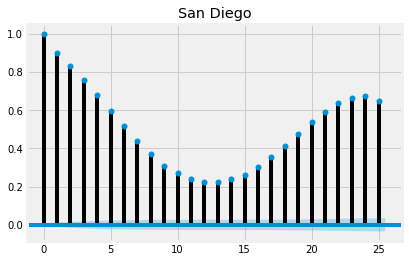

In [43]:
# Autocorrelation of humidity of San Diego
plot_acf(humidity["San Diego"],lags=25,title="San Diego")
plt.show()

In [44]:
# Partial Autocorrelation of humidity of San Diego
plot_pacf(humidity["San Diego"],lags=25)
plt.show()

In [45]:
# Partial Autocorrelation of closing price of microsoft stocks
plot_pacf(microsoft["Close"],lags=25)
plt.show()

## 3. Time series decomposition and Random walks

### 3.1 Trends, seasonality and noise

These are the components of a time series

* Trend - Consistent upwards or downwards slope of a time series
* Seasonality - Clear periodic pattern of a time series(like sine function)
* Noise - Outliers of missing value


* time series decomposition - 시계열 분해
* trend - 추세
* seasonality - 계절성
* residual - 잔차

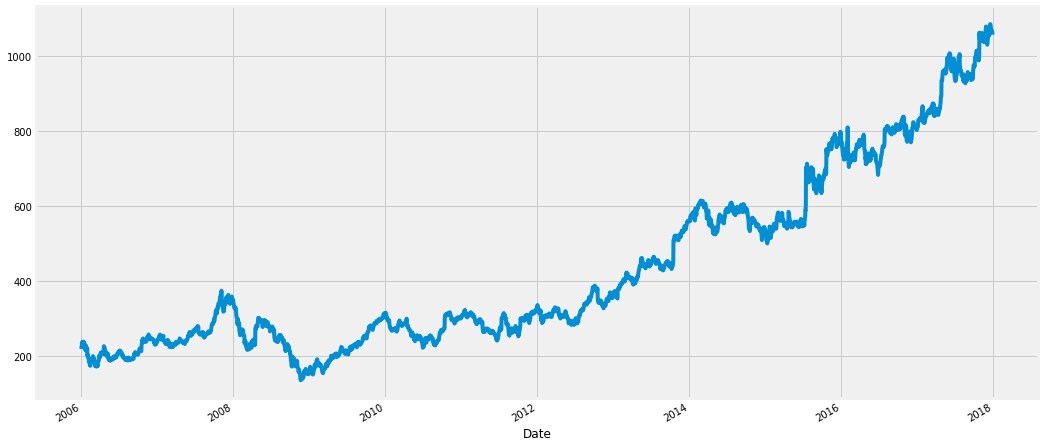

In [46]:
# 구글 주식의 high값 그래프

google["High"].plot(figsize=(16,8))

### statsmodels 패키지

링크: https://datascienceschool.net/view-notebook/77ee0e1bb6754ad89e0da14c6d461953/



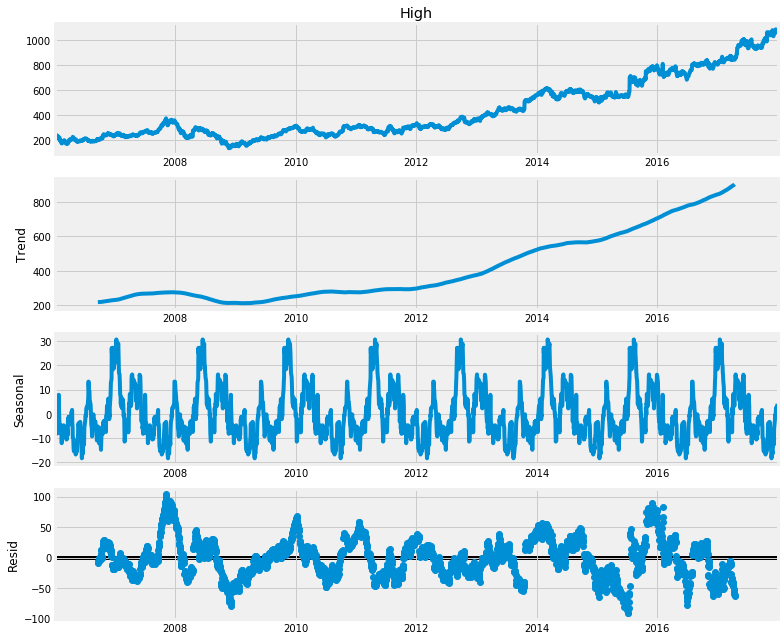

In [47]:
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"], freq=360)
figure = decomposed_google_volume.plot()
plt.show()

* 명확하게 추세선은 상향그래프임
* 일정한 계절성을 가짐
* 일정하지 않은 noise 이것들은 outliner 와 missing value를 나타낸다

## 3.2 White noise (백색소음)

* 상수 평균
* 상수 분산
* lags 사이에는 상관 관계가 없음

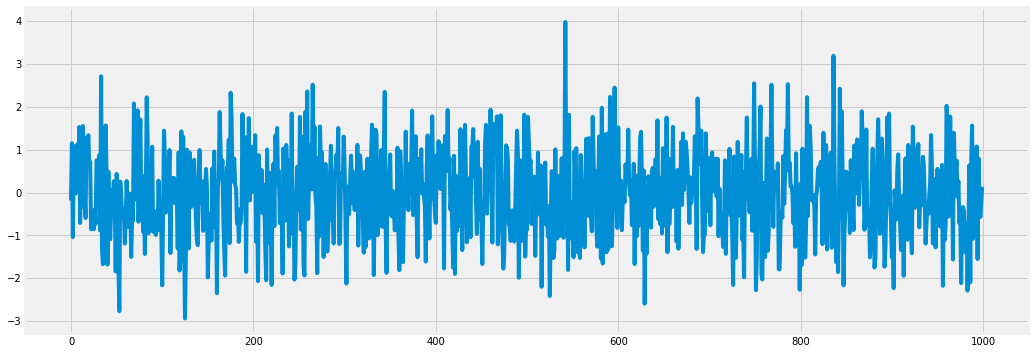

In [48]:
# Plotting white noise
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
plt.plot(white_noise)

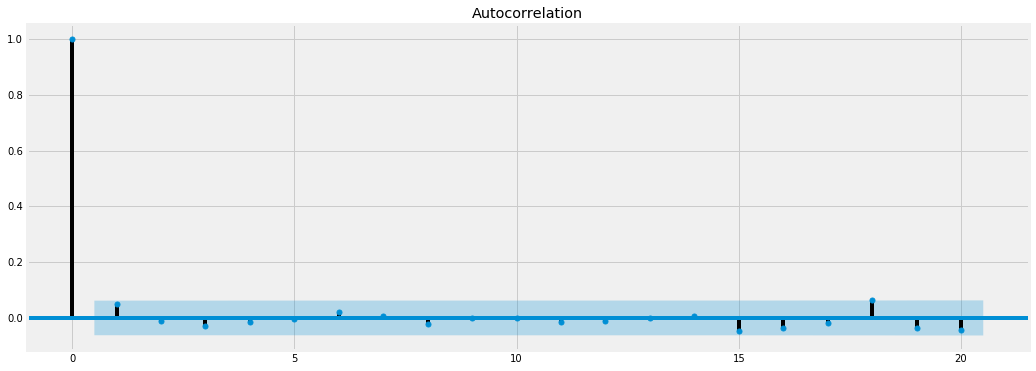

In [49]:
# Plotting autocorrelation of white noise
# white noise 의 자기상관계수 그래프 그려보기
plot_acf(white_noise,lags=20)
plt.show()

## 3.3 Random Walk

* 정상성 (stationarity) https://freshrimpsushi.tistory.com/907

시계열 데이터의 평균과 분산이 일정할 때 정상성을 갖는다고 한다.
-> 데이터가 정상성을 가진다는 것은 아주 좋은 일이며, 사실 시계열 분석을 사용하기 위한 필수조건이라고 할 수 있다.

* Dickey-Fuller test https://freshrimpsushi.tistory.com/921

디키-풀러 테스트는 시계열 데이터가 정상성을 가지는지 가지지 않는지를 확인할 때 사용한다.

* ADF 검정 https://chukycheese.github.io/translation/statistics/augmented-dickey-fuller-test/

Augmented Dickey Fuller(ADF) 검정은 정상성을 알아보기 위한 단위 검정 방법이다. Dickey-Fuller 검정보다 더 복잡한 모형들을 다룰 수 있으며, 더 강력하기도 하다.

In [50]:
adf = adfuller(microsoft["Volume"])
print("p-value of microsoft: {}".format(float(adf[1])))
adf = adfuller(google["Volume"])
print("p-value of google: {}".format(float(adf[1])))

p-value of microsoft: 0.000320152527765203
p-value of google: 6.51071960576848e-07


microsoft-volume, google-volume 둘 다 p-value 가 0.05 보다 작으므로 random walk 가 아니다  
-> 데이터가 정상성을 가진다

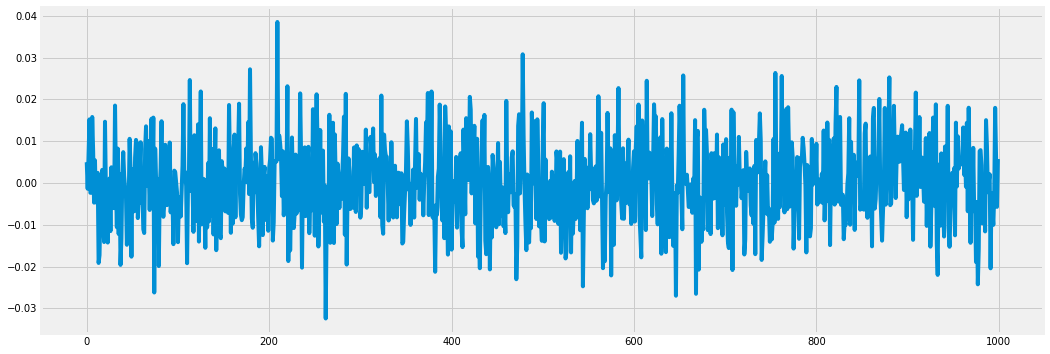

In [51]:
# generating a random walk

seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

* random walk https://m.blog.naver.com/PostView.nhn?blogId=bhp516&logNo=220553414564&proxyReferer=https:%2F%2Fwww.google.com%2F

In [52]:
fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
iplot(fig, filename='Basic Distplot')

## 3.4 Stationarity

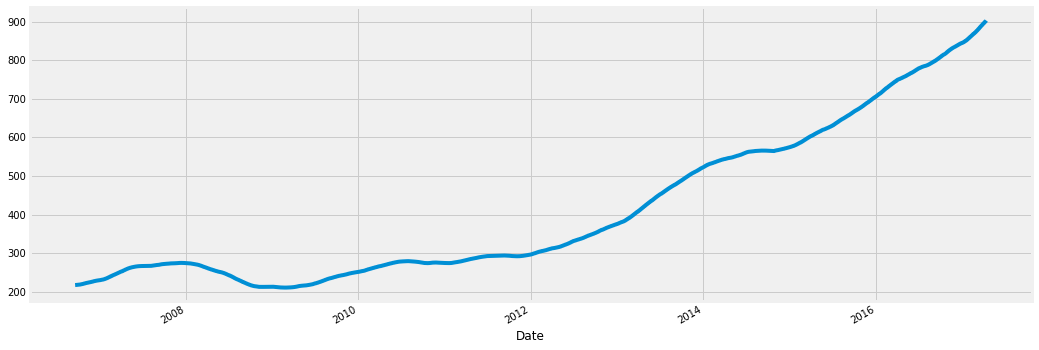

In [53]:
# The original non-stationary plot
# 추세선
decomposed_google_volume.trend.plot()

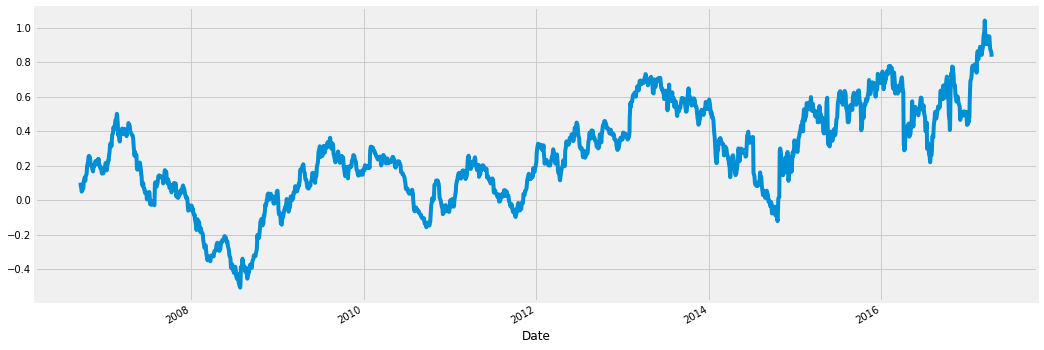

In [54]:
# The new stationary plot
# 추세선 변환 그래프
decomposed_google_volume.trend.diff().plot()

# 4. Modelling using statstools

* AR, MA, ARMA, ARIMA 를 설명함  
https://lazyer.tistory.com/28  
https://statkclee.github.io/statistics/stat-time-series-arma.html  
https://m.blog.naver.com/bluefish850/220749045909  
https://datascienceschool.net/view-notebook/9987e98ec60946c79a8a7f37cb7ae9cc/

## 4.1 AR models

In [55]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

In [56]:
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.701
Method:                       css-mle   S.D. of innovations              0.996
Date:                Sun, 10 May 2020   AIC                           2837.403
Time:                        13:16:03   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.288      2.454      0.014       0.142       1.272
ar.L1.y        0.8916      0.014     62.742      0.000       0.864       0.919
                                    Roots                                    
    

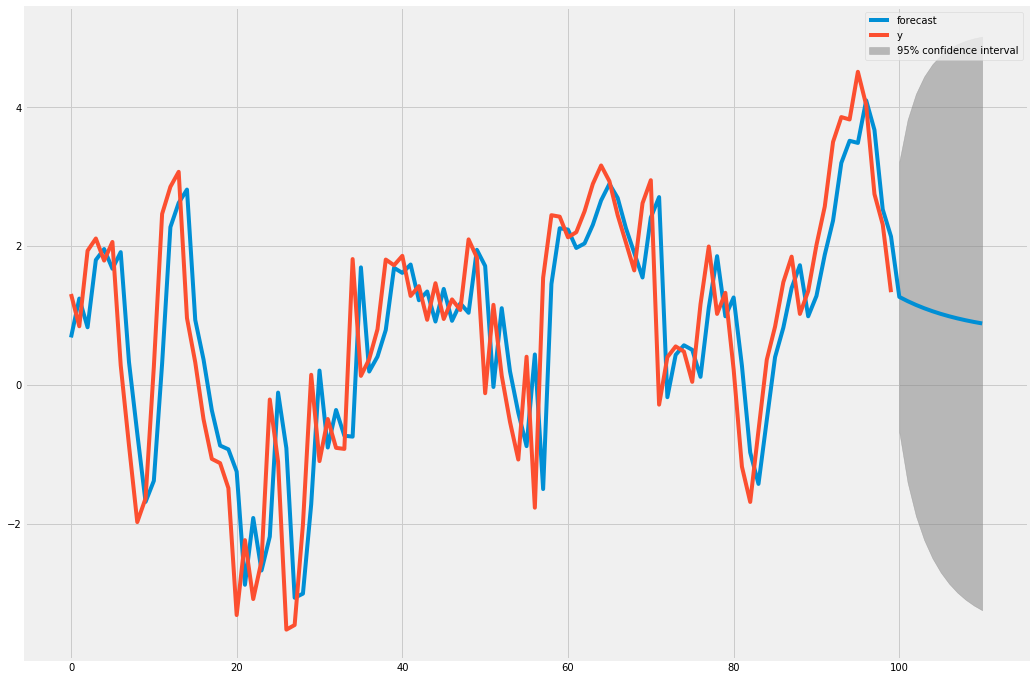

In [57]:
# Predicting simulated AR(1) model 

result.plot_predict(start=900, end=1010)
plt.show()

In [58]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408054512080593.


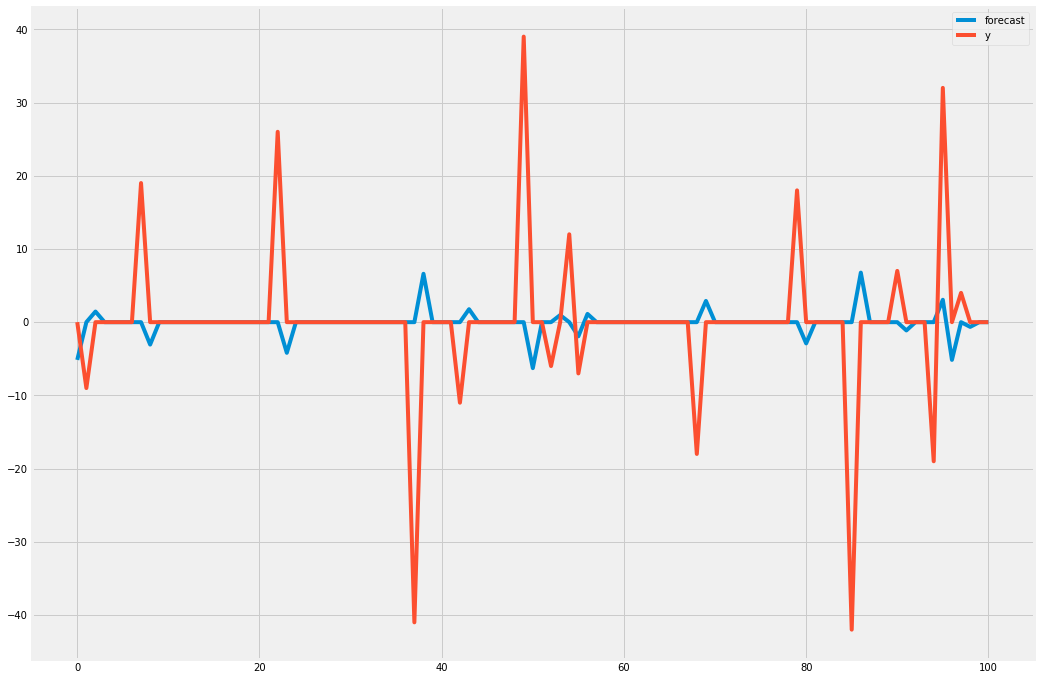

In [59]:
# Predicting humidity level of Montreal
humid = ARMA(humidity["Montreal"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=1000, end=1100)
plt.show()

In [60]:
rmse = math.sqrt(mean_squared_error(humidity["Montreal"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 7.218388577563986.


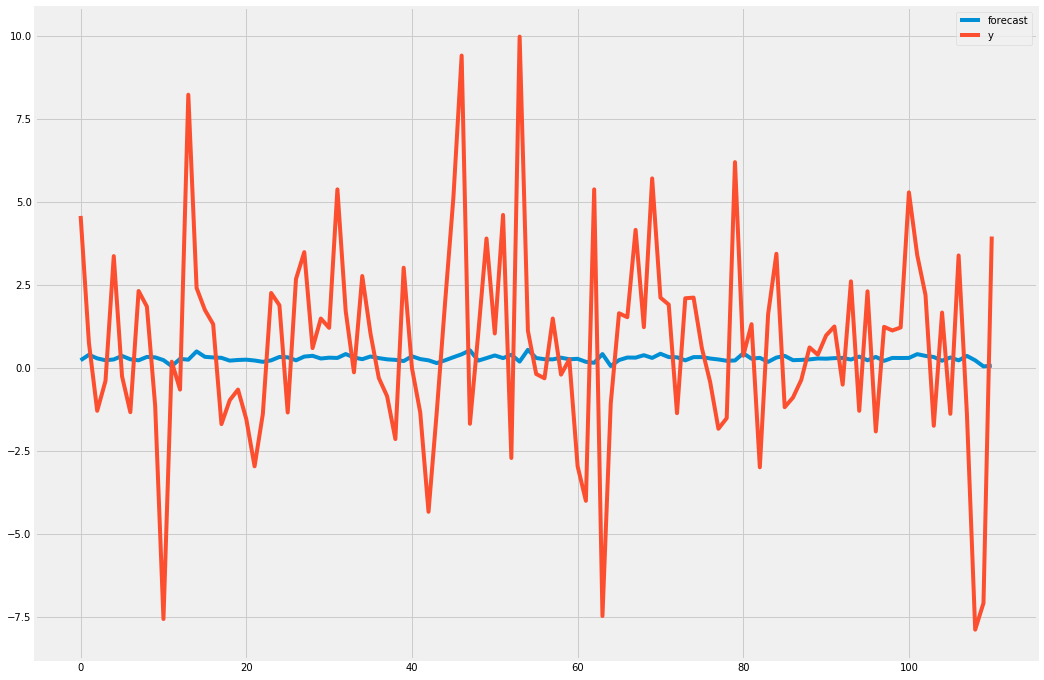

In [61]:
# Predicting closing prices of google
humid = ARMA(google["Close"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=900, end=1010)
plt.show()

## 4.2 MA models

In [62]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
plt.plot(sim1)

In [63]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1423.276
Method:                       css-mle   S.D. of innovations              1.004
Date:                Sun, 10 May 2020   AIC                           2852.553
Time:                        13:18:38   BIC                           2867.276
Sample:                             0   HQIC                          2858.148
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.014     -1.652      0.099      -0.050       0.004
ma.L1.y       -0.5650      0.027    -20.797      0.000      -0.618      -0.512
                                    Roots                                    
    

ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                45251
Model:                     ARMA(0, 3)   Log Likelihood             -153516.982
Method:                       css-mle   S.D. of innovations              7.197
Date:                Sun, 10 May 2020   AIC                         307043.965
Time:                        13:18:51   BIC                         307087.564
Sample:                             0   HQIC                        307057.686
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.031     -0.025      0.980      -0.061       0.060
ma.L1.y       -0.1621      0.005    -34.507      0.000      -0.171      -0.153
ma.L2.y        0.0386      0.005      8.316      0.000       0.030       0.048
ma.

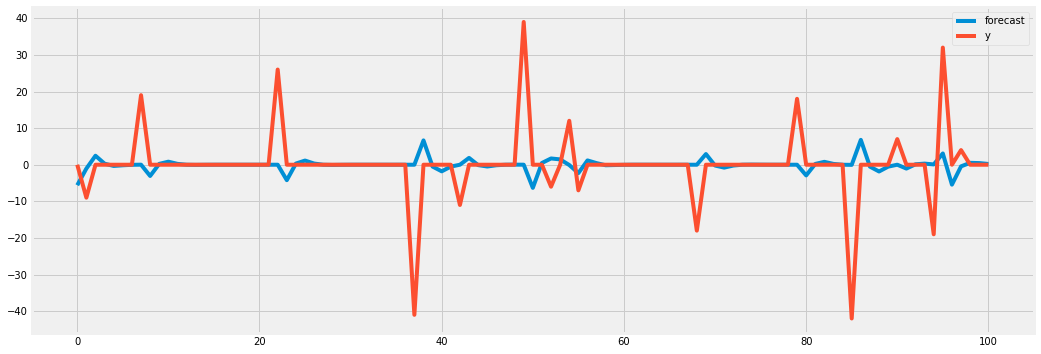

In [64]:
# Forecasting and predicting montreal humidity
model = ARMA(humidity["Montreal"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [65]:
rmse = math.sqrt(mean_squared_error(humidity["Montreal"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 11.34512885961698.


## 4.3 ARMA models

ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(3, 3)   Log Likelihood              -55408.974
Method:                       css-mle   S.D. of innovations       22751607.182
Date:                Sun, 10 May 2020   AIC                         110833.948
Time:                        13:19:36   BIC                         110882.047
Sample:                             0   HQIC                        110851.244
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.03e+04   9913.535     -2.047      0.041   -3.97e+04    -867.048
ar.L1.y        0.2052      0.160      1.287      0.198      -0.107       0.518
ar.L2.y        0.7297      0.179      4.081      0.000       0.379       1.080
ar.

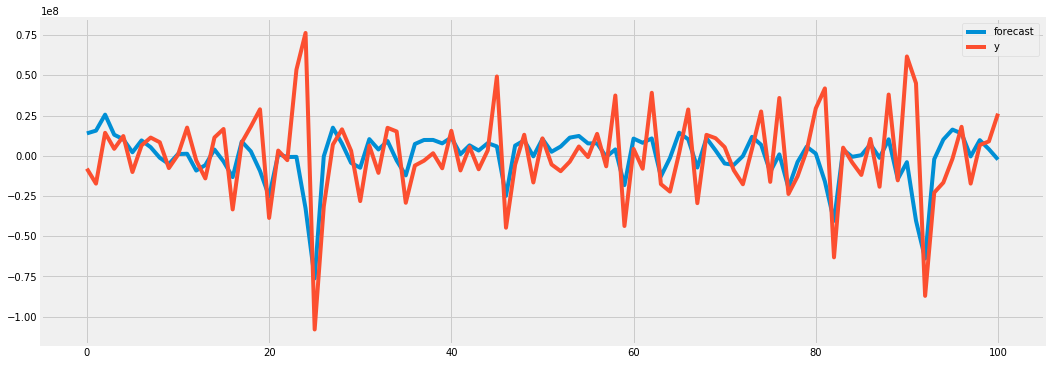

In [66]:
# Forecasting and predicting microsoft stocks volume
model = ARMA(microsoft["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [67]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 38038242.61642569.


## 4.4 ARIMA models

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -56385.467
Method:                       css-mle   S.D. of innovations       31647215.008
Date:                Sun, 10 May 2020   AIC                         112778.933
Time:                        13:20:03   BIC                         112802.981
Sample:                             1   HQIC                        112787.581
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9984.0302   2.48e+05      0.040      0.968   -4.75e+05    4.95e+05
ar.L1.D.y     -0.8716      0.016    -53.758      0.000      -0.903      -0.840
ar.L2.D.y     -0.4551      0.016    -28.071      0.000      -0.487      -0.423
  

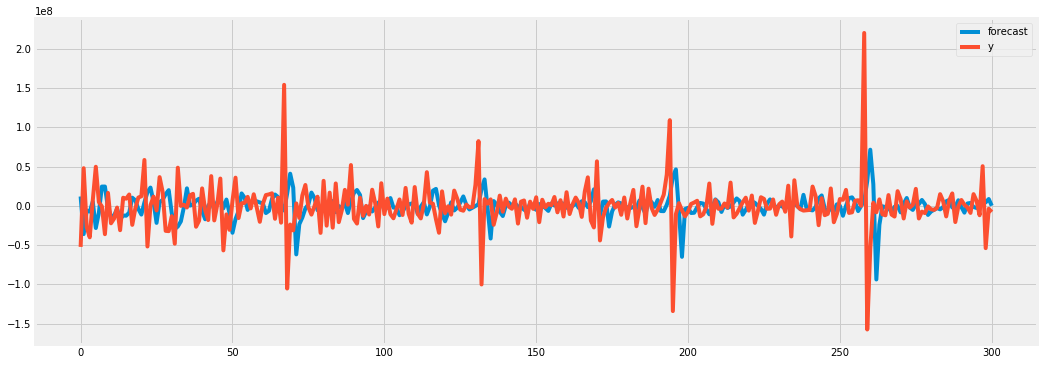

In [68]:
# Predicting the microsoft stocks volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(microsoft["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
plt.show()

In [69]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 61937614.65140498.
